# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')
sys.path.append('../../')

In [3]:
import pandas as pd
from fairness.helpers import *
from fairness.avd_helpers import *
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.optim as optim
import time

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import aif360 as aif

from aif360.algorithms.inprocessing import AdversarialDebiasing
import tensorflow.compat.v1 as tf
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import LFR

#import skorch
#from skorch.net import NeuralNet as NN
import matplotlib.patches as mpatches


torch.manual_seed(1)
np.random.seed(7)
sns.set(style="white", palette="colorblind", color_codes=True, context="talk")
sns.set_theme()

tf.disable_eager_execution()

pip install 'aif360[LawSchoolGPA]'
2023-02-09 16:38:06.078007: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


# Loading Data

In [4]:
df = pd.read_csv('../../data/dutch/dutch.csv')

In [5]:
df.head()

,sex,age,household_position,household_size,prev_residence_place,citizenship,country_birth,edu_level,economic_status,cur_eco_activity,Marital_status,occupation
0,1,6,1131,112,1,1,1,5,111,135,1,2_1
1,2,10,1122,113,1,1,1,2,111,122,2,5_4_9
2,1,8,1122,113,1,1,1,2,111,122,2,2_1
3,1,12,1121,112,1,1,1,1,111,137,2,5_4_9
4,2,4,1110,114,1,1,1,2,111,138,1,5_4_9


In [6]:
df.columns = [c.strip() for c in df.columns]

In [7]:
data = df.assign(sex = df.sex.map({1: 'male', 2: 'female'}),
         occupation_high_level = df.occupation.map({'2_1': 1, '5_4_9': 0}),
         moved_recently = df.prev_residence_place.map({1:0, 2:1}),
         citizenship = df.citizenship.map({1: 'netherlands', 2: 'europe', 3: 'rest_of_world'}),
         country_birth = df.country_birth.map({1: 'netherlands', 2: 'europe', 3: 'rest_of_world'}),
         marital_status = df.Marital_status.map({1: 'single', 2: 'married', 3: 'widowed', 4: 'divorced'}),
         economic_status=df.economic_status.map({111: '111', 120: '120', 112: '112'}))\
    .drop(columns=['household_position', 'household_size', 'cur_eco_activity', 'occupation'])
data.head()

,sex,age,prev_residence_place,citizenship,country_birth,edu_level,economic_status,Marital_status,occupation_high_level,moved_recently,marital_status
0,male,6,1,netherlands,netherlands,5,111,1,1,0,single
1,female,10,1,netherlands,netherlands,2,111,2,0,0,married
2,male,8,1,netherlands,netherlands,2,111,2,1,0,married
3,male,12,1,netherlands,netherlands,1,111,2,0,0,married
4,female,4,1,netherlands,netherlands,2,111,1,0,0,single


## Split Data and Train Biased Model

In [8]:
(X_train, X_test, y_train, y_test, Z_train, Z_test) = split_scale_pipe(pd.get_dummies(data.drop(columns=['sex', 'occupation_high_level'])),
                                                                      data.occupation_high_level,
                                                                      (data.sex=='male').astype(int),
                                                                      stratify=data.occupation_high_level)

In [9]:
train_data = BinaryLabelDataset(df=X_train.assign(occupation_high_level = y_train, sex=Z_train), label_names=['occupation_high_level'], 
                                protected_attribute_names=['sex'])
test_data = BinaryLabelDataset(df=X_test.assign(occupation_high_level=y_test, sex=Z_test), label_names=['occupation_high_level'],
                               protected_attribute_names=['sex'])


tf.reset_default_graph()
sess = tf.Session()


privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

biased_model = AdversarialDebiasing(unprivileged_groups=unprivileged_groups,
                 privileged_groups=privileged_groups,
                 scope_name='classifier',
                 debias=False,
                 sess=sess).fit(train_data)

preds = biased_model.predict(test_data)
acc = metrics.accuracy_score(y_test, preds.labels)
b_acc = metrics.balanced_accuracy_score(y_test, preds.labels)
prule = p_rule(preds.labels, Z_test)

2023-02-09 16:38:11.174023: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
2023-02-09 16:38:11.331667: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled


epoch 0; iter: 0; batch classifier loss: 0.761194
epoch 0; iter: 200; batch classifier loss: 0.403348
epoch 1; iter: 0; batch classifier loss: 0.443197
epoch 1; iter: 200; batch classifier loss: 0.396592
epoch 2; iter: 0; batch classifier loss: 0.473236
epoch 2; iter: 200; batch classifier loss: 0.463243
epoch 3; iter: 0; batch classifier loss: 0.433476
epoch 3; iter: 200; batch classifier loss: 0.377906
epoch 4; iter: 0; batch classifier loss: 0.456884
epoch 4; iter: 200; batch classifier loss: 0.388321
epoch 5; iter: 0; batch classifier loss: 0.374195
epoch 5; iter: 200; batch classifier loss: 0.445200
epoch 6; iter: 0; batch classifier loss: 0.329281
epoch 6; iter: 200; batch classifier loss: 0.367683
epoch 7; iter: 0; batch classifier loss: 0.322340
epoch 7; iter: 200; batch classifier loss: 0.348341
epoch 8; iter: 0; batch classifier loss: 0.311581
epoch 8; iter: 200; batch classifier loss: 0.406317
epoch 9; iter: 0; batch classifier loss: 0.360491
epoch 9; iter: 200; batch classi

In [10]:
print(f'accuracy = {acc * 100}%')
print(f'balanced accuracy = {b_acc * 100}%')
print(f'p-rule = {prule}%')

accuracy = 83.00562727573652%
balanced accuracy = 82.96204187925656%
p-rule = 45.64851989241833%


In [12]:
test_results = pd.DataFrame(Z_test).assign(biased_pred = preds.labels, target=y_test)
test_results = test_results.assign(biased_score = preds.scores)

### LFR

In [13]:
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

train_bld = BinaryLabelDataset(df=X_train.assign(occupation_high_level = y_train, sex=Z_train),
                              label_names=['occupation_high_level'],
                              protected_attribute_names=['sex'])

test_bld =  BinaryLabelDataset(df=X_test.assign(occupation_high_level = y_test, sex=Z_test),
                              label_names=['occupation_high_level'],
                              protected_attribute_names=['sex'])

start = time.time()
lfr = LFR(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
    Az=8
         ).fit(train_bld)

new_train_data = lfr.transform(train_bld)
new_test_data = lfr.transform(test_bld)

tf.reset_default_graph()
sess = tf.Session()


privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

model = AdversarialDebiasing(unprivileged_groups=unprivileged_groups,
                 privileged_groups=privileged_groups,
                 scope_name='classifier',
                 debias=False,
                 sess=sess).fit(new_train_data)

preds = model.predict(new_test_data)
acc = metrics.accuracy_score(y_test, preds.labels)
b_acc = metrics.balanced_accuracy_score(y_test, preds.labels)
prule = p_rule(preds.labels, Z_test)

print(f'accuracy = {acc * 100}%')
print(f'balanced accuracy = {b_acc * 100}%')
print(f'p-rule = {prule}%')

epoch 0; iter: 0; batch classifier loss: 0.836795
epoch 0; iter: 200; batch classifier loss: 0.088764
epoch 1; iter: 0; batch classifier loss: 0.078043
epoch 1; iter: 200; batch classifier loss: 0.061212
epoch 2; iter: 0; batch classifier loss: 0.054752
epoch 2; iter: 200; batch classifier loss: 0.069888
epoch 3; iter: 0; batch classifier loss: 0.054460
epoch 3; iter: 200; batch classifier loss: 0.047107
epoch 4; iter: 0; batch classifier loss: 0.078947
epoch 4; iter: 200; batch classifier loss: 0.075377
epoch 5; iter: 0; batch classifier loss: 0.053373
epoch 5; iter: 200; batch classifier loss: 0.032771
epoch 6; iter: 0; batch classifier loss: 0.048712
epoch 6; iter: 200; batch classifier loss: 0.027037
epoch 7; iter: 0; batch classifier loss: 0.051880
epoch 7; iter: 200; batch classifier loss: 0.028208
epoch 8; iter: 0; batch classifier loss: 0.024256
epoch 8; iter: 200; batch classifier loss: 0.025936
epoch 9; iter: 0; batch classifier loss: 0.033859
epoch 9; iter: 200; batch classi

In [14]:
print(f'accuracy = {acc*100:.2f}%')
print(f'balanced accuracy = {b_acc*100:.2f}%')
print(f'p-rule = {prule:.2f}%')

accuracy = 75.17%
balanced accuracy = 74.90%
p-rule = 98.49%


In [15]:
test_results = test_results.assign(lfr_pred = preds.labels,
                                  lfr_change = preds.labels.flatten() - test_results.biased_pred)

### Advesarial Debiasing

In [16]:
import fairlearn_int
import fairness.avd_helpers as avh
from fairlearn_int.adversarial import AdversarialFairnessClassifier

In [17]:
adfl = AdversarialFairnessClassifier(predictor_model=[200, nn.ReLU()], 
                                    adversary_model=avh.Adversary_old(),
                                    alpha=10.86)

In [18]:
adfl_ = adfl.fit(X=X_train, y=y_train, sensitive_features=Z_train)

In [19]:
preds = adfl_.predict(X_test)
preds.index=X_test.index
acc = metrics.accuracy_score(y_test, preds) * 100
b_acc = metrics.balanced_accuracy_score(y_test, preds) * 100
prule = p_rule(preds, Z_test.values)

print(f'accuracy = {acc:.2f}%')
print(f'balanced accuracy = {b_acc:.2f}%')
print(f'p-rule = {prule:.2f}%')

accuracy = 70.36%
balanced accuracy = 69.81%
p-rule = 95.44%


In [20]:
test_results = test_results.assign(adv_pred = preds, adv_change = preds - test_results.biased_pred)

### Advesarial Debiasing (Equal Odds)

In [40]:
import fairlearn_int
import fairness.avd_helpers as avh
from fairlearn_int.adversarial import AdversarialFairnessClassifier

In [41]:
adfl = AdversarialFairnessClassifier(predictor_model=[200, nn.ReLU()], 
                                    adversary_model=[128, nn.ReLU(), 128, nn.ReLU(), 128, nn.ReLU()],
                                    constraints='equalized_odds',
                                    alpha=130)

In [42]:
adfl_ = adfl.fit(X=X_train, y=y_train, sensitive_features=Z_train)

In [43]:
preds = adfl_.predict(X_test)
preds.index=X_test.index

test_results = test_results.assign(
    adveq_pred = preds,
    adveq_change = preds - test_results.biased_pred
)

In [44]:
acc = metrics.accuracy_score(y_test, preds) * 100
b_acc = metrics.balanced_accuracy_score(y_test, preds) * 100
dm = disparate_mistreatment(test_results[['sex', 'target', 'adveq_pred']].rename({'adveq_pred':'fair_label'}, axis=1), 'sex')

print(f'disparate mistreatement: D(FPR) = {dm[0]:.2f}, D(TPR) = {dm[1]:.2f}')
print(f'accuracy = {acc:.2f}%')
print(f'balanced accuracy = {b_acc:.2f}%')

disparate mistreatement: D(FPR) = 1.07, D(TPR) = 1.25
accuracy = 75.56%
balanced accuracy = 75.81%


### Equal Odds

In [70]:
import fairlearn_int
from fairlearn_int.postprocessing import ThresholdOptimizer as TOp

In [71]:
bld_train = BinaryLabelDataset(df=X_train.join(y_train).join(Z_train), label_names=['occupation_high_level'], protected_attribute_names=['sex'])

In [72]:
m = TOp(estimator=biased_model, constraints='equalized_odds',
        predict_method='predict', prefit=True).fit(X=torch.Tensor(X_train.assign(sex=Z_train).set_index('sex').to_numpy()),
                                                                           y=torch.Tensor(y_train.to_numpy()),
                                                                           sensitive_features=torch.Tensor(Z_train.to_numpy()),
                                                                           Z=Z_train, 
                                                                           bld=bld_train)

In [73]:
preds = m.predict(X=X_test,
                  sensitive_features=torch.Tensor(Z_test.to_numpy()),
                  y=y_test,
                  Z=Z_test,
                  bld=test_data
                 )

In [74]:
acc = metrics.accuracy_score(y_test, preds) * 100
b_acc = metrics.balanced_accuracy_score(y_test, preds) * 100
dm = disparate_mistreatment(test_results[['sex', 'target', 'adveq_pred']].rename({'adveq_pred':'fair_label'}, axis=1), 'sex')

print(f'accuracy = {acc:.2f}%')
print(f'balanced accuracy = {b_acc:.2f}%')
print(f'disparate mistreatement: D(FPR) = {dm[0]:.2f}, D(TPR) = {dm[1]:.2f}')

accuracy = 79.48%
balanced accuracy = 78.98%
disparate mistreatement: D(FPR) = 1.07, D(TPR) = 1.25


In [75]:
test_results = test_results.assign(eq_pred = preds, eq_change = preds-test_results.biased_pred)

### Reject Option Classification

In [52]:
from fairness.avd_helpers import RejectOptionClassifier

In [53]:
scores = biased_model.predict(test_data).scores.flatten()
labels = biased_model.predict(test_data).labels.flatten()

preds = RejectOptionClassifier(0.92).predict(scores, Z_test.values)

In [55]:
print(f'accuracy = {metrics.accuracy_score(y_test, labels)*100:.2f}%')
print(f'balanced accuracy = {metrics.balanced_accuracy_score(y_test, labels)*100:.2f}%')
print(f'p-rule = {p_rule(scores, Z_test):.2f}%')

print('-------------')
print('debiased:')

print(f'accuracy = {metrics.accuracy_score(y_test, preds)*100:.2f}%')
print(f'balanced accuracy = {metrics.balanced_accuracy_score(y_test, preds)*100:.2f}%')
print(f'p-rule = {p_rule(preds, Z_test):.2f}%')

accuracy = 83.01%
balanced accuracy = 82.96%
p-rule = 45.65%
-------------
debiased:
accuracy = 76.21%
balanced accuracy = 75.32%
p-rule = 96.91%


In [56]:
test_results = test_results.assign(roc_pred=preds, roc_change = preds - test_results.biased_pred)

# Comparisons

In [59]:
t = test_results

In [67]:
metrics_ = get_metrics(
    [t[['sex', 'target', 'lfr_pred', 'biased_pred']].rename({'biased_pred': 'biased_label', 'lfr_pred':'fair_label'}, axis=1),
     t[['sex', 'target', 'adv_pred']].rename({'adv_pred':'fair_label'}, axis=1),
     t[['sex', 'target', 'roc_pred']].rename({'roc_pred':'fair_label'}, axis=1),
     t[['sex', 'target', 'adveq_pred']].rename({'adveq_pred':'fair_label'}, axis=1),
     t[['sex', 'target', 'eq_pred']].rename({'eq_pred':'fair_label'}, axis=1)],
    ['adversarial (dem parity)','LFR',  'ROC', 'adversarial (eq odds)', 'eq odds'],
    sensitive_feature='sex'
)

metrics_.drop(columns=['class 0 accuracy', 'class 1 accuracy'])

,approach,accuracy,balanced accuracy,p% rules,fpr_diffs,tpr_diffs
0,adversarial (dem parity),0.751672,0.748985,98.491631,15.934801,17.523836
1,LFR,0.703608,0.698110,95.437786,6.107890,16.017999
2,ROC,0.762099,0.753223,96.905933,2.898521,28.962601
3,adversarial (eq odds),0.755611,0.758074,75.427701,1.072992,1.252312
4,eq odds,0.795200,0.790147,63.125638,0.452289,0.020152
5,biased,0.830056,0.829620,45.648520,24.819729,9.681503


## How many instances does each method change ?

In [76]:
comp_df = test_results

In [77]:
eq_changed = len(comp_df[comp_df.eq_change!=0])
adv_changed = len(comp_df[comp_df.adv_change!=0])
lfr_changed = len(comp_df[comp_df.lfr_change!=0])
roc_changed = len(comp_df[comp_df.roc_change!=0])
adveq_changed = len(comp_df[comp_df.adveq_change!=0])

eq_perc = eq_changed / len(comp_df) * 100
adv_perc = adv_changed / len(comp_df)* 100
lfr_perc = lfr_changed / len(comp_df)* 100
roc_perc = roc_changed / len(comp_df)* 100
adveq_perc = adveq_changed / len(comp_df)* 100

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'LFR'),
  Text(1, 0, 'Adversarial (DP)'),
  Text(2, 0, 'ROC'),
  Text(3, 0, 'Adversarial (EO)'),
  Text(4, 0, 'TO')])

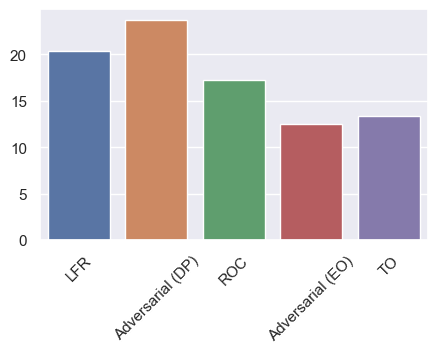

In [80]:
fig, axs = plt.subplots(1,1,figsize=(5,3))

sns.barplot(x=['LFR', 'Adversarial (DP)', 'ROC', 'Adversarial (EO)', 'TO'], y=[lfr_perc, adv_perc, roc_perc, adveq_perc, eq_perc])
plt.xticks(rotation=45)


In [81]:
print(f'percentage of predictions changed by adversarial: {adv_perc:.2f}%')
print(f'percentage of predictions changed by lfr: {lfr_perc:.2f}%')
print(f'percentage of predictions changed by roc: {roc_perc:.2f}%')
print(f'percentage of predictions changed by adversarial (equal odds): {adveq_perc:.2f}%')
print(f'percentage of predictions changed by equal odds: {eq_perc:.2f}%')

percentage of predictions changed by adversarial: 23.67%
percentage of predictions changed by lfr: 20.36%
percentage of predictions changed by roc: 17.24%
percentage of predictions changed by adversarial (equal odds): 12.51%
percentage of predictions changed by equal odds: 13.30%


In [84]:
inters = len(comp_df[(comp_df.adv_change!=0) & (comp_df.lfr_change!=0) & (comp_df.roc_change!=0)])
union = len(comp_df[(comp_df.adv_change!=0) | (comp_df.lfr_change!=0) | (comp_df.roc_change!=0)])
iou_dp = inters / union * 100

inters = len(comp_df[(comp_df.adveq_change!=0) & (comp_df.eq_change!=0)])
union = len(comp_df[(comp_df.adveq_change!=0) | (comp_df.eq_change!=0)])
iou_eo = inters / union * 100


print(f'IOU(DP) = {iou_dp:.2f}%')
print(f'IOU(EO) = {iou_eo:.2f}%')

IOU(DP) = 19.38%
IOU(EO) = 6.55%


## Are these the same instances ?

How many instances were changed by just one method, how many by two, and how many by three ?

<AxesSubplot:xlabel='num_changes', ylabel='perc'>

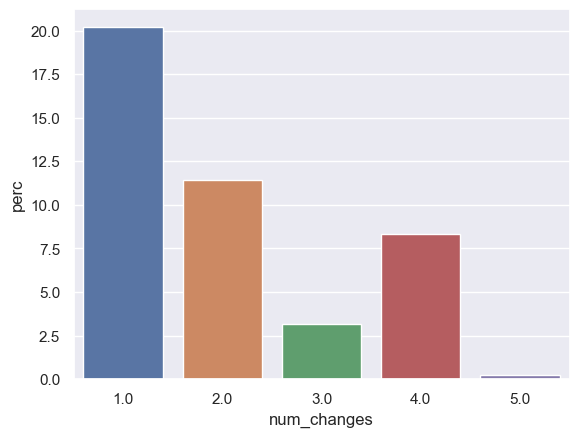

In [85]:
comp_df = comp_df.assign(
    num_changes = abs(comp_df.eq_change) + abs(comp_df.adv_change) + abs(comp_df.lfr_change) + abs(comp_df.roc_change) + abs(comp_df.adveq_change)
)

plot_df = comp_df.groupby('num_changes').count()[['sex']].reset_index().rename({'sex':'num'}, axis=1)
plot_df = plot_df[plot_df.num_changes!=0].assign(perc = round(plot_df.num / len(comp_df) * 100, 2))
sns.barplot(data=plot_df, x='num_changes', y='perc')

### Values achieved by each 

In [86]:
num_women = len(comp_df[comp_df.sex==0])
num_men = len(comp_df[comp_df.sex==1])

In [87]:
lfr_perc_women = len(comp_df[(comp_df.sex==0) & (comp_df.lfr_pred==1)]) / num_women * 100
lfr_perc_men = len(comp_df[(comp_df.sex==1) & (comp_df.lfr_pred==1)]) / num_men * 100

adv_perc_women = len(comp_df[(comp_df.sex==0) & (comp_df.adv_pred==1)]) / num_women * 100
adv_perc_men = len(comp_df[(comp_df.sex==1) & (comp_df.adv_pred==1)]) / num_men * 100

roc_perc_women = len(comp_df[(comp_df.sex==0) & (comp_df.roc_pred==1)]) / num_women * 100
roc_perc_men = len(comp_df[(comp_df.sex==1) & (comp_df.roc_pred==1)]) / num_men * 100

adveq_perc_women = len(comp_df[(comp_df.sex==0) & (comp_df.adveq_pred==1)]) / num_women * 100
adveq_perc_men = len(comp_df[(comp_df.sex==1) & (comp_df.adveq_pred==1)]) / num_men * 100

eq_perc_women = len(comp_df[(comp_df.sex==0) & (comp_df.eq_pred==1)]) / num_women * 100
eq_perc_men = len(comp_df[(comp_df.sex==1) & (comp_df.eq_pred==1)]) / num_men * 100

In [88]:
print('LFR:')
print(f'{lfr_perc_women:.2f}% of women classified positively')
print(f'{lfr_perc_men:.2f}% of men classified positively')
print()

print('Adversarial:')
print(f'{adv_perc_women:.2f}% of women classified positively')
print(f'{adv_perc_men:.2f}% of men classified positively')
print()

print('ROC:')
print(f'{roc_perc_women:.2f}% of women classified positively')
print(f'{roc_perc_men:.2f}% of men classified positively')
print()

LFR:
43.53% of women classified positively
42.87% of men classified positively

Adversarial:
36.70% of women classified positively
38.46% of men classified positively

ROC:
29.79% of women classified positively
30.74% of men classified positively



### Focus:

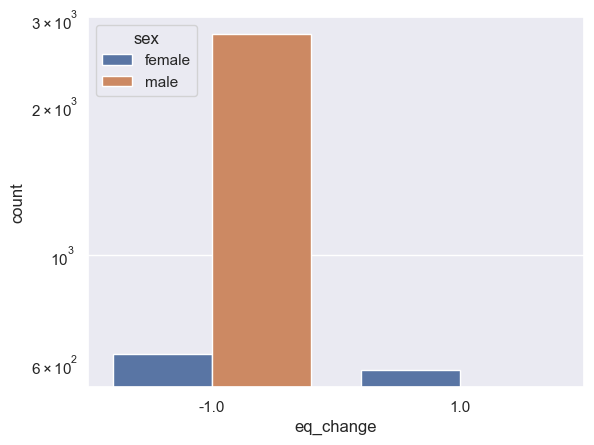

In [89]:
plt_eq = comp_df[comp_df.eq_change!=0].assign(sex = comp_df.sex.map(lambda x: 'male' if x==1 else 'female')).groupby(['sex', 'eq_change']).count()[['biased_pred']].rename({'biased_pred':'count'}, axis=1).reset_index().assign(method = 'Equal Odds')

g = sns.barplot(data=plt_eq, x='eq_change', y='count', hue='sex')
g.set_yscale('log')

In [90]:
plt_eq

,sex,eq_change,count,method
0,female,-1.0,630,Equal Odds
1,female,1.0,585,Equal Odds
2,male,-1.0,2802,Equal Odds


<AxesSubplot:xlabel='adv_change', ylabel='count'>

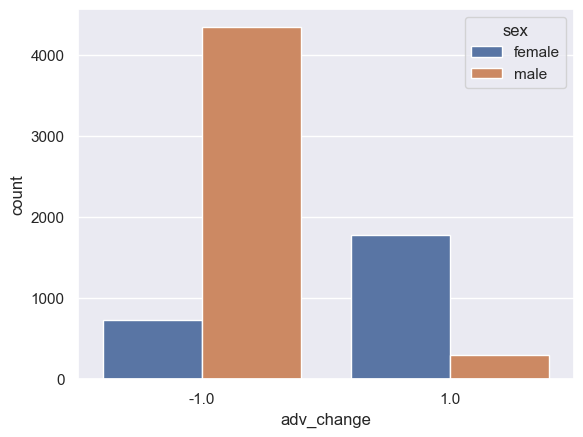

In [91]:
plt_adv = comp_df[comp_df.adv_change!=0].assign(sex = comp_df.sex.map(lambda x: 'male' if x==1 else 'female')).groupby(['sex', 'adv_change']).count()[['biased_pred']].rename({'biased_pred':'count'}, axis=1).reset_index()

sns.barplot(data=plt_adv, x='adv_change', y='count', hue='sex')

## Are these the same people ?

In [92]:
# DP
changed_union = comp_df[(comp_df.adv_change!=0) | (comp_df.lfr_change!=0) | (comp_df.roc_change!=0)]
changed_intersect = comp_df[(comp_df.adv_change!=0) & (comp_df.lfr_change!=0) & (comp_df.roc_change!=0)]

perc_intersect = len(changed_intersect) / len(changed_union) * 100

print('Demographic Parity:')
print(f'Of all the predictions changed by at least one method, {perc_intersect:.2f}% were changed by all three')

# EO
changed_union = comp_df[(comp_df.adveq_change!=0) | (comp_df.eq_change!=0)]
changed_intersect = comp_df[(comp_df.adveq_change!=0) & (comp_df.eq_change!=0)]

perc_intersect = len(changed_intersect) / len(changed_union) * 100

print('Equal Odds:')
print(f'Of all the predictions changed by at least one method, {perc_intersect:.2f}% were changed by both')

# All
changed_union = comp_df[(comp_df.adv_change!=0) | (comp_df.lfr_change!=0) | (comp_df.roc_change!=0) | (comp_df.adveq_change!=0) | (comp_df.eq_change!=0)]
changed_intersect = comp_df[(comp_df.adv_change!=0) & (comp_df.lfr_change!=0) & (comp_df.roc_change!=0) & (comp_df.adveq_change!=0) & (comp_df.eq_change!=0)]

perc_intersect = len(changed_intersect) / len(changed_union) * 100

print('All methods:')
print(f'Of all the predictions changed by at least one method, {perc_intersect:.2f}% were changed by all five')


Demographic Parity:
Of all the predictions changed by at least one method, 19.38% were changed by all three
Equal Odds:
Of all the predictions changed by at least one method, 6.55% were changed by both
All methods:
Of all the predictions changed by at least one method, 0.48% were changed by all five


## T-SNE

In [94]:
a_df = comp_df[comp_df.adv_change!=0]
l_df = comp_df[comp_df.lfr_change!=0]
e_df = comp_df[comp_df.eq_change!=0]
r_df = comp_df[comp_df.roc_change!=0]
ae_df = comp_df[comp_df.adveq_change!=0]

In [95]:
from sklearn.manifold import TSNE

tsne_df = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=(50)).fit_transform(X_test)


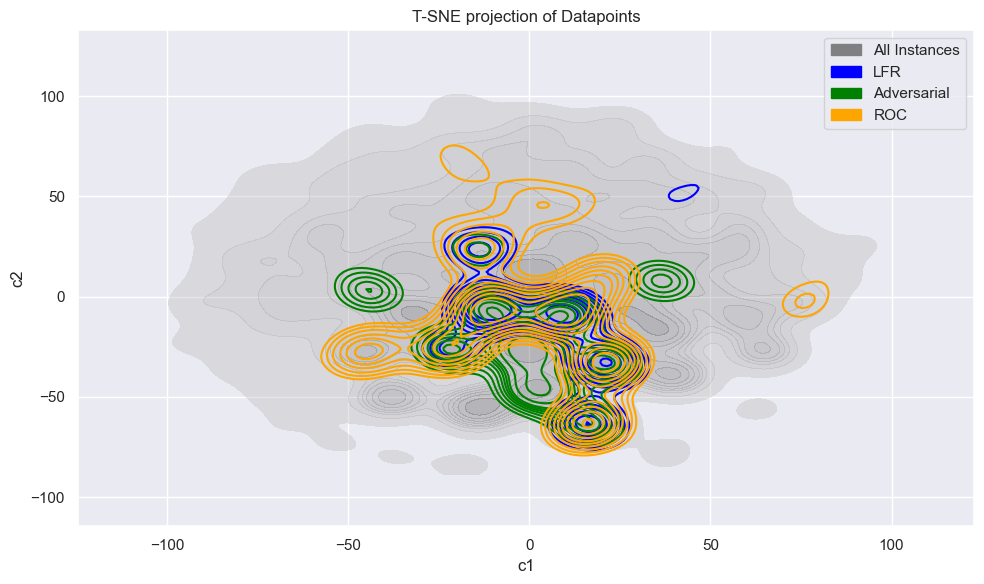

In [96]:
#from fairness.helpers import *

tsne_plot(
    pd.DataFrame(tsne_df, index=X_test.index, columns=['c1', 'c2']),
    {'LFR': l_df, 'Adversarial':a_df, 'ROC':r_df},
    {'LFR': 'Blue', 'Adversarial':'Green', 'ROC':'Orange'}
)

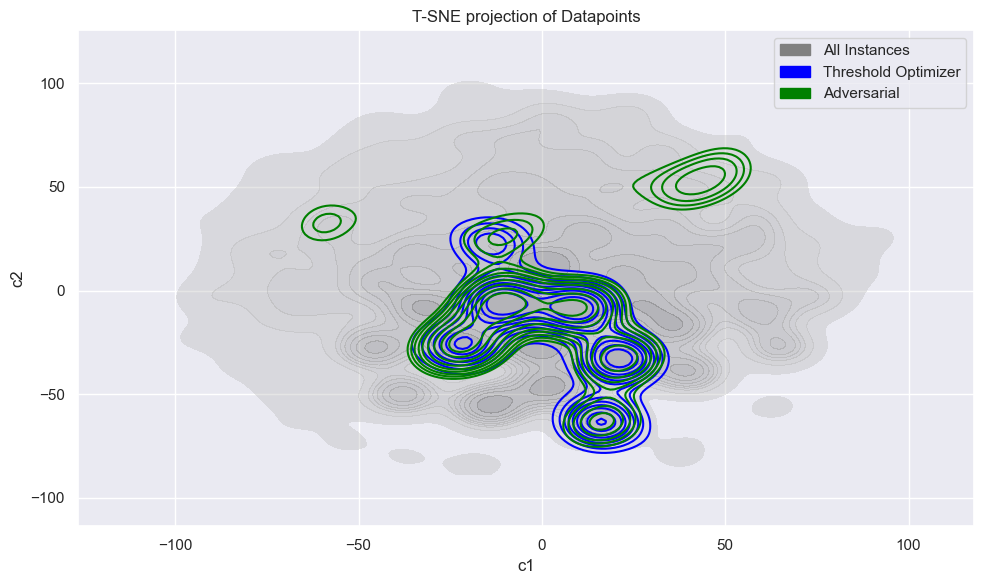

In [97]:
tsne_plot(
    pd.DataFrame(tsne_df, index=X_test.index, columns=['c1', 'c2']),
    {'Threshold Optimizer': e_df, 'Adversarial':ae_df},
    {'Threshold Optimizer': 'Blue', 'Adversarial':'Green'}
)

In [92]:
import discrepancies as disc
from discrepancies import pool
from discrepancies import DIG

In [186]:
class LFR_model:
    
    def __init__(self, lfr, model):
        self.lfr = lfr
        self.model = model
        
    def fit(self):
        pass
    
    def predict(self, XZ):
        
        bld = BinaryLabelDataset(df = XZ.assign(occupation_high_level = 0),
                                label_names=['occupation_high_level'],
                                protected_attribute_names=['sex'])
        df = self.lfr.transform(bld).convert_to_dataframe()[0].drop(columns=['sex', 'occupation_high_level'])
        
        return self.model.predict(torch.Tensor(df.to_numpy()))
    
class EQ_model:
    
    def __init__(self, model):
        self.model = model
        
    def fit(self):
        pass
    
    def predict(self, XZ):
        return self.model.predict(X=torch.Tensor(XZ.drop(columns=['sex']).to_numpy()),
                                  sensitive_features=torch.Tensor(XZ['sex'].to_numpy()))
    
class Simple_Model:
    
    def __init__(self, model):
        self.model = model
        
    def fit(self):
        pass
    
    def predict(self, XZ):
        return (self.model.predict(torch.Tensor(XZ.drop(columns=['sex']).to_numpy()))>0.5).astype(int)

In [187]:
lfr_wrap = LFR_model(lfr, lfr_clf)
eq_wrap = EQ_model(m)
adv_wrap = Simple_Model(adfl_)
biased_wrap = Simple_Model(biased_clf)

In [188]:
eq_pool = pool.FairnessPool([eq_wrap, biased_wrap], ['Equal Odds', 'Biased'], 'sex')
adv_pool = pool.FairnessPool([adv_wrap, biased_wrap], ['Adversarial', 'Biased'], 'sex')
lfr_pool = pool.FairnessPool([lfr_wrap, biased_wrap], ['LFR', 'Biased'], 'sex')

In [189]:
check = lfr_pool.predict(XZ=X_test.join(Z_test))
check = check.assign(
    Biased = (check.Biased>0.5).astype(int),
    sex=Z_test,
    target=y_test,
    LFR = (check.LFR>0.5).astype(int)
)

In [190]:
print(p_rule(check['LFR'], check.sex))
print(metrics.accuracy_score(check.target, check['LFR'])*100)
print(metrics.balanced_accuracy_score(check.target, check['LFR'])*100)

85.88032168836781
78.37140019860973
77.97714771565829


In [191]:
sample = X_test.join(Z_test).sample(250)#.assign(occupation_high_level=0)

In [195]:
dd = adv_pool.predict_discrepancies(sample)
dd.head()

,Adversarial,Biased,discrepancies
30420,0,0,0
53894,0,0,0
5414,1,1,0
23560,1,1,0
44438,0,0,0


In [196]:
X_test.head(1)

,age,prev_residence_place,edu_level,Marital_status,moved_recently,citizenship_europe,citizenship_netherlands,citizenship_rest_of_world,country_birth_europe,country_birth_netherlands,country_birth_rest_of_world,economic_status_111,economic_status_112,economic_status_120,marital_status_divorced,marital_status_married,marital_status_single,marital_status_widowed
6235,1.16054,-0.15703,-0.972347,0.270881,-0.15703,-0.11686,0.141013,-0.077852,-0.162263,0.280256,-0.222497,0.417491,-0.274791,-0.291301,-0.250593,0.802157,-0.692149,-0.09281


In [197]:
X_test.columns

Index(['age', 'prev_residence_place', 'edu_level', 'Marital_status',
       'moved_recently', 'citizenship_europe', 'citizenship_netherlands',
       'citizenship_rest_of_world', 'country_birth_europe',
       'country_birth_netherlands', 'country_birth_rest_of_world',
       'economic_status_111', 'economic_status_112', 'economic_status_120',
       'marital_status_divorced', 'marital_status_married',
       'marital_status_single', 'marital_status_widowed'],
      dtype='object')

In [202]:
digger = DIG.Digger(
    sample,#.drop(columns=['occupation_high_level']),
    y_test,#sample.occupation_high_level,
    eq_pool,
    categorical_names=['Marital_status',
       'moved_recently', 'citizenship_europe', 'citizenship_netherlands',
       'citizenship_rest_of_world', 'country_birth_europe',
       'country_birth_netherlands', 'country_birth_rest_of_world',
       'economic_status_111', 'economic_status_112', 'economic_status_120',
       'marital_status_divorced', 'marital_status_married',
       'marital_status_single', 'marital_status_widowed']
).fit(max_epochs=7)

INFO:root:### EPOCH #1
INFO:root:### EPOCH #2


epoch 1
(82, 19)
epoch 2
(1039, 19)


INFO:root:### EPOCH #3


epoch 3
(2400, 19)


INFO:root:### EPOCH #4


epoch 4
(3274, 19)


INFO:root:### EPOCH #5


epoch 5
(4859, 19)


INFO:root:### EPOCH #6


epoch 6
(7803, 19)


INFO:root:### EPOCH #7


epoch 7
(13928, 19)


In [206]:
nodes = pd.concat(
    [digger.get_nodes_attributes(digger.get_nodes())[0],
    digger.get_nodes_attributes(digger.get_nodes())[1]],
    axis=1
).assign(
    discrepancy = lambda x: (x['Equal Odds']!=x['Biased']).astype(int)
)

In [207]:
nodes.head()

,age,prev_residence_place,edu_level,Marital_status,moved_recently,citizenship_europe,citizenship_netherlands,citizenship_rest_of_world,country_birth_europe,country_birth_netherlands,...,economic_status_112,economic_status_120,marital_status_divorced,marital_status_married,marital_status_single,marital_status_widowed,sex,Equal Odds,Biased,discrepancy
30420,-1.824153,-0.15703,-1.737869,-1.102851,-0.15703,-0.11686,0.141013,-0.077852,-0.162263,0.280256,...,3.639132,-0.291301,-0.250593,-1.246639,1.444776,-0.09281,1.0,0,0,0
53894,-0.544999,-0.15703,-0.206825,0.270881,-0.15703,-0.11686,0.141013,-0.077852,-0.162263,0.280256,...,-0.274791,-0.291301,-0.250593,0.802157,-0.692149,-0.09281,0.0,0,0,0
5414,0.307770,-0.15703,-0.206825,0.270881,-0.15703,-0.11686,0.141013,-0.077852,-0.162263,0.280256,...,-0.274791,3.432870,-0.250593,0.802157,-0.692149,-0.09281,0.0,1,1,0
23560,0.307770,-0.15703,1.324218,0.270881,-0.15703,-0.11686,0.141013,-0.077852,-0.162263,0.280256,...,-0.274791,-0.291301,-0.250593,0.802157,-0.692149,-0.09281,0.0,1,1,0
44438,-0.971383,-0.15703,-0.972347,-1.102851,-0.15703,-0.11686,0.141013,-0.077852,-0.162263,0.280256,...,-0.274791,-0.291301,-0.250593,-1.246639,1.444776,-0.09281,1.0,0,0,0


In [310]:
#(X_train, X_test, y_train, y_test, Z_train, Z_test) = split_scale_pipe(pd.get_dummies(data.drop(columns=['sex', 'occupation_high_level'])),
#                                                                      data.occupation_high_level,
#                                                                      (data.sex=='male').astype(int),
#                                                                      stratify=data.occupation_high_level)

X = pd.get_dummies(data.drop(columns=['sex', 'occupation_high_level', 'marital_status']))
y = data.occupation_high_level
Z = (data.sex=='male').astype(int)

In [313]:
X.head()

,age,prev_residence_place,edu_level,Marital_status,moved_recently,citizenship_europe,citizenship_netherlands,citizenship_rest_of_world,country_birth_europe,country_birth_netherlands,country_birth_rest_of_world,economic_status_111,economic_status_112,economic_status_120
0,6,1,5,1,0,0,1,0,0,1,0,1,0,0
1,10,1,2,2,0,0,1,0,0,1,0,1,0,0
2,8,1,2,2,0,0,1,0,0,1,0,1,0,0
3,12,1,1,2,0,0,1,0,0,1,0,1,0,0
4,4,1,2,1,0,0,1,0,0,1,0,1,0,0


In [231]:
(trainx, testx, trainy, testy,
     trainz, testz) = train_test_split(X, y, Z, test_size=0.5,
                                         stratify=y, random_state=11)

scaler = StandardScaler().fit(trainx)

nodes_unscaled = pd.DataFrame(scaler.inverse_transform(nodes[~nodes.index.isin(X.index)][X_test.columns]), columns=X_test.columns,
            index=nodes.index[~nodes.index.isin(X.index)])
nodes_unscaled.head()

,age,prev_residence_place,edu_level,Marital_status,moved_recently,citizenship_europe,citizenship_netherlands,citizenship_rest_of_world,country_birth_europe,country_birth_netherlands,country_birth_rest_of_world,economic_status_111,economic_status_112,economic_status_120,marital_status_divorced,marital_status_married,marital_status_single,marital_status_widowed
60420,5.0,1.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
60421,5.0,1.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
60422,5.0,1.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
60423,5.0,1.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
60424,5.0,1.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [250]:
df = pd.concat([nodes_unscaled, X.loc[~X.index.isin(nodes_unscaled.index) & X.index.isin(nodes.index)]])\
    .join(nodes[['Equal Odds', 'Biased', 'discrepancy']])

df.head()

,age,prev_residence_place,edu_level,Marital_status,moved_recently,citizenship_europe,citizenship_netherlands,citizenship_rest_of_world,country_birth_europe,country_birth_netherlands,...,economic_status_111,economic_status_112,economic_status_120,marital_status_divorced,marital_status_married,marital_status_single,marital_status_widowed,Equal Odds,Biased,discrepancy
60420,5.0,1.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0
60421,5.0,1.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0
60422,5.0,1.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0
60423,5.0,1.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0
60424,5.0,1.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0


In [252]:
x_tree_train, x_tree_test, y_tree_train, y_tree_test = train_test_split(df.drop(columns=['Equal Odds', 'Biased', 'discrepancy']),
                                                                       df[['discrepancy']],
                                                                       test_size=0.5, stratify=df[['discrepancy']], random_state=11)

In [288]:
from sklearn.tree import DecisionTreeClassifier

dec_tree = DecisionTreeClassifier(max_depth=5)
dec_tree = dec_tree.fit(x_tree_train,
                       y_tree_train)

In [289]:
preds = dec_tree.predict(x_tree_test)
metrics.balanced_accuracy_score(y_tree_test, preds)

0.6099550533029375

In [290]:
import graphviz
from sklearn import tree

In [291]:
dot_data = tree.export_graphviz(dec_tree, out_file=None, feature_names=list(X_test.columns), class_names=['not changed', 'changed'])
graph = graphviz.Source(dot_data)

In [292]:
graph.render('dutch_eq')

'dutch_eq.pdf'

In [304]:
x_tree_train, x_tree_test, y_tree_train, y_tree_test = train_test_split(dff.drop(columns=['Equal Odds', 'Biased', 'discrepancy']),
                                                                       dff[['discrepancy']],
                                                                       test_size=0.5, stratify=dff[['discrepancy']], random_state=11)
scaler = StandardScaler().fit(x_tree_train)
scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), 
                                               columns=df.columns, index=df.index)
x_train = x_tree_train.pipe(scale_df, scaler)
x_test = x_tree_test.pipe(scale_df, scaler)

In [307]:
from sklearn.tree import DecisionTreeClassifier

dec_tree = DecisionTreeClassifier(max_depth=5)
dec_tree = dec_tree.fit(x_train,
                       y_tree_train)

In [308]:
preds = dec_tree.predict(x_tree_test)
metrics.balanced_accuracy_score(y_tree_test, preds)

0.4990382781085771

In [294]:
df.columns

Index(['age', 'prev_residence_place', 'edu_level', 'Marital_status',
       'moved_recently', 'citizenship_europe', 'citizenship_netherlands',
       'citizenship_rest_of_world', 'country_birth_europe',
       'country_birth_netherlands', 'country_birth_rest_of_world',
       'economic_status_111', 'economic_status_112', 'economic_status_120',
       'marital_status_divorced', 'marital_status_married',
       'marital_status_single', 'marital_status_widowed', 'Equal Odds',
       'Biased', 'discrepancy'],
      dtype='object')